In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import torchvision.models as models
from PIL import Image

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-04199b69-af8a-9287-0d66-bbc964a5fc57)


In [3]:
pip install pillow-lut

Note: you may need to restart the kernel to use updated packages.


In [4]:
from scripts.serverside.captcha.image import ImageCaptcha
from tqdm import tqdm
import os
import string
import random

In [5]:
def get_random_string(length):
    # choose from all lowercase letter
    letters = "abcdefghjkmnpqrstuvwxyz" + "ABCDEFGHIJKLMNPQRSTUVWXYZ" + "23456789" + "     "
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [6]:
from torchvision.transforms.transforms import Grayscale
# Load datasets
# Label formated as 2D tensor of indexed as [place][tokenID]
chars = "abcdefghijklmnpqrstuvwxyz123456789 " # use " " as null character. Leave out o and 0, also case insensitive
charIndex = {}
for i, char in enumerate(chars):
    charIndex[char] = i

idn = torch.eye(len(chars)).cuda()

def strToOH(string):
    oneHot = []
    for char in string:
      oneHot.append(idn[charIndex[char]])
    return torch.stack(oneHot)

def strToInd(string):
    oneHot = []
    for char in string:
      oneHot.append(torch.tensor(charIndex[char]))
    return torch.stack(oneHot)

In [7]:
do_cuda = True

In [8]:
def get_accuracy(model, train=False, batch_size = 64):
    if train:
        data = captchaPreProcLarge
    else:
        data = TrawSetVal #TODO: seperate validation set

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        if do_cuda and torch.cuda.is_available:
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        for i in range(8):
            #select index with maximum prediction score
            digit = output[:, :, i]
            #print(digit.shape)
            pred = digit.max(1, keepdim=True)[1]
            pred = pred.squeeze()
            #print(pred.shape)
            #print(labels[:, i].shape)
            correct += pred.eq(labels[:, i]).sum().item()
            total += imgs.shape[0]
    return correct / total
  



def train(model, data, batch_size=64, num_epochs=30, learning_rate=0.0001):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []


    startTime = time.time() # to see how long training goes
    print("starting training")
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        
        try:
            data.flush()
            train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        except Exception:
            pass
        print("epoch: ", epoch)
        for imgs, labels in iter(train_loader):

            if do_cuda and torch.cuda.is_available:
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            #print(out[0])
            #print()
            #print(labels[0])
            #print()
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1

        #train_acc.append(get_accuracy(model, train=True, batch_size=batch_size)) # compute training accuracy 
        val_acc.append(get_accuracy(model, train=False, batch_size=batch_size))  # compute validation accuracy
        print(("Epoch {}: |"+"Validation acc: {}").format(
                epoch, # call epoch zero epoch zero
                
                val_acc[-1]))
        
        #checkpoint
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
        torch.save(model.state_dict(), path)


    
    finishTime = time.time()

    delta = finishTime - startTime
    print("\nDONE TRAINING in %s seconds!\n" % delta)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    #plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [9]:
class TCacheSet():
    def __init__(self, size, period):
        self.size = size
        self.cached = []
        self.period = period
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush()
    def flush(self):
        self.cached.clear()
        for index in range(self.period):
            label = get_random_string(8)
            data = self.IC.generate_image(label)
            data = run_denoiser.execute_pix2pix_denoise(global_denoising, data)
            data = self.transform(data)
            label = label.lower().replace(" ", "")
            label += " " * (8 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1]

    def __len__(self):
        return self.size

class TFrozenSet():
    def __init__(self, size):
        self.size = size
        self.cached = []
        self.period = size
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush2()
    def flush2(self):
        self.cached.clear()
        for index in range(self.period):
            label = get_random_string(8)
            data = self.IC.generate_image(label)
            data = run_denoiser.execute_pix2pix_denoise(global_denoising, data)
            data = self.transform(data)
            label = label.lower().replace(" ", "")
            label += " " * (8 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1]

    def __len__(self):
        return self.size

class TransferCaptcha(nn.Module):
    def __init__(self):
        super(TransferCaptcha, self).__init__()
        self.name = "TransferCaptcha"
        conv = models.resnext50_32x4d(pretrained=True)
        self.conv = conv
        self.layer1 = nn.Linear(1000, 512)
        self.layer2 = nn.Linear(512, len(chars) * 8)

    def forward(self, x, x2=0):
        
        x = self.conv(x)

        x = x.view(-1, 1000) # flatten convolution output for ANN
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        x = x.view(-1, len(chars), 8)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x  

initialize network with normal


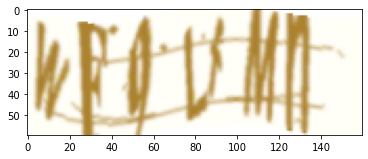

In [10]:
import run_denoiser
global_denoising = run_denoiser.load_pix2pix_CAPTCHA()
from matplotlib.pyplot import imshow
label = get_random_string(8)
IC_test = ImageCaptcha()
data = IC_test.generate_image(label)
imshow(np.asarray(data))
data = run_denoiser.execute_pix2pix_denoise(global_denoising, data)

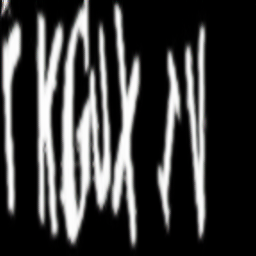

In [14]:
data

In [10]:
TpreNet = TransferCaptcha()
state = torch.load("checkpoints/model_TransferCaptcha_bs64_lr2.11231203e-05_epoch27")
TpreNet.load_state_dict(state)
TpreNet.cuda()
#train(TpreNet, TbiggerSet, batch_size=64, num_epochs = 100, learning_rate=0.001103)

TransferCaptcha(
  (conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [11]:

TrawSetVal = TFrozenSet(1500)

In [17]:
TbiggerSet = TCacheSet(8192, 1024)

In [18]:
train(TpreNet, TbiggerSet, batch_size=32, num_epochs = 250, learning_rate=0.0001)

starting training
epoch:  0


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 10.00 GiB total capacity; 7.28 GiB already allocated; 0 bytes free; 7.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="max_split_size_mb:128"
torch.cuda.empty_cache()
import gc
gc.collect()

430

In [13]:
def get_full_accuracy(model, train=False, batch_size = 64):
    if train:
        data = captchaPreProcLarge
    else:
        data = TrawSetVal #TODO: seperate validation set

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        if do_cuda and torch.cuda.is_available:
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        for i in range(imgs.shape[0]):
            #select index with maximum prediction score
            out = output[i, :, :]
            #print(out.shape)
            #print(digit.shape)
            pred = out.max(0, keepdim=True)[1]
            pred = pred.squeeze()
            #print(pred.shape)
            #print(labels[:, i].shape)
            #print(labels[i, :].shape)
            #print(pred.shape)
            correct += int(pred.eq(labels[i, :]).sum().item() == 8)
            total += 1
    return correct / total

In [ ]:
print("FULL ACCURACY: {}".format(get_full_accuracy(TpreNet, train=False, batch_size = 32)))